# Numberlink

---
## Setup

### Import libraries

In [15]:
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from seaborn import heatmap
# import networkx as nx
import queue

### Define the Numberlink puzzle class

In [16]:
class Numberlink:
    def __init__(self, paper: np.ndarray):
        self.paper = paper
        self.ends : Dict[int, List[Tuple[int, int]]] = {}
        (height, width) = paper.shape
        for i in range(height):
            for j in range(width):
                pos = (i, j)
                if paper[pos]:
                    if paper[pos] not in self.ends:
                        self.ends[paper[pos]] = [pos]
                    else:
                        self.ends[paper[pos]].append(pos)
    @property
    def shape(self):
        return self.paper.shape
    @property
    def cmap(self):
        hsv = plt.get_cmap('hsv')
        colors = [(1, 1, 1)] + [hsv(i) for i in range(1, 256)]
        return LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    @property
    def nNumber(self):
        return len(self.ends)

### Define the action set (directions)

In [17]:
LEFT = (0, -1)
RIGHT = (0, 1)
UP = (-1, 0)
DOWN = (1, 0)
DIRECTIONS = (RIGHT, DOWN, LEFT, UP)

### Define the helper functions

In [20]:
def getNeighborPos(pos: Tuple[int, int], direction: Tuple[int, int]) -> Tuple[int, int]:
    ''' Get the position of the neighbor cell in the given direction
        pos: Position of the current cell
        direction: direction to the current cell
        return: Position of the neighbor cell
    '''
    return (pos[0] + direction[0], pos[1] + direction[1])


def isInBorder(pos: Tuple[int, int], shape: Tuple[int, int]) -> bool:
    ''' Check if a position is in the border of the grid
        pos: Position to check
        shape: Shape of the puzzle paper
        return: True if the position is in the border, False otherwise
    '''
    return pos[0] >= 0 and pos[0] < shape[0] and pos[1] >= 0 and pos[1] < shape[1]


def printEmptyPaper(puzzle: Numberlink):
    ''' Print the unsolved puzzle corresponding to a numeric/empty grid
        puzzle: A Numberlink puzzle
    '''
    (height, width) = puzzle.shape
    
    print()
    for i in range(height + 1):
        for _ in range(width):
            print("+", end="")
            print("---" if i % height == 0 else "   ", end="")
        print("+")
        if (i >= height):
            break
        for j in range(width):
            print(" " if j else "|", end="")
            if puzzle.paper[i, j] == 0:
                print("   ", end="")
                continue
            print("{:03d}".format(puzzle.paper[i, j]), end="")
        print("|")


def showPaper(puzzle: Numberlink):
    ''' Display the paper corresponding to a empty/numeric/connected grid
        Display ending positions of each number on the grid 
        puzzle: A Numberlink puzzle
        Output: Heatmap grid of the puzzle with markers
    '''
    (height, width) = puzzle.shape
    paper = 255 * (puzzle.paper / puzzle.nNumber)
    
    f = plt.figure(figsize = (width,height))
    heatmap(paper, vmin = 0, vmax = 255, cmap = puzzle.cmap, annot=puzzle.paper, cbar = False, xticklabels=False, yticklabels=False)

---
## Create a sample puzzle

Puzzle of dimensions (3, 3)

+---+---+---+
|001        |
+   +   +   +
|    002    |
+   +   +   +
|002 001    |
+---+---+---+


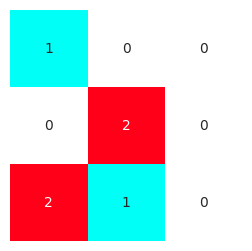

In [19]:
# Create the puzzle
# 0: empty grid, reachable within a path
# other numbers: ending positions of cooresponding numbers

paper = np.array(
          [[1, 0, 0],
           [0, 2, 0],
           [2, 1, 0]]
        )
puzzle = Numberlink(paper)

# Print the puzzle using helper functions
print("Puzzle of dimensions", puzzle.shape)
printEmptyPaper(puzzle)
showPaper(puzzle)

---
## Solution based on Backtracking

### Goal Test Predicates

Consider the Numberlink puzzle as a problem similar to the map coloring problem -- we need to try to color the whole "map" with colors. But in Numberlink, the **goals** change to:
1. No number is positioned within the path of any line.
    - i.e. If a grid is an end-point with a specific color (number) `k`, **EXACTLY one** of its neighboring grids can also be colored as `k`.
2. Lines do not branch or intersect.
    - i.e. If a grid is NOT an end-point, it can be colored as `k` only if **EXACTLY two** of its neighboring grids are also colored as `k`.

In [22]:
def isSolved(puzzle: Numberlink):
    ''' Check if the puzzle is solved
        puzzle: A Numberlink puzzle
        return: True if the puzzle is solved, False otherwise
    '''
    pass

### Backtracking Search

In [ ]:
# Solution based on backtracking

def solve1(puzzle: Numberlink) -> bool:
    ''' Solve the Numberlink puzzle using backtracking
        puzzle: A Numberlink puzzle
        return: True if the puzzle is solved, False if impossible to solve
    '''
    pass

---
## Solution based on Constraint Propagation

### Constraints
1. No number is positioned within the path of any line.
    - i.e. If a grid is an **end-point** with a specific color (number) `k` and has **four filled neighbors** (including borders), **EXACTLY one** of its neighboring grids can also be colored as `k`.
2. Lines do not branch or intersect.
    - i.e. If a **non-empty** grid is **NOT an end-point** and has **four filled neighbors** (including borders), it can be colored as `k` only if **EXACTLY two** of its neighboring grids are also colored as `k`.

In [ ]:
# Constraint checking function
def countNeighbors(puzzle: Numberlink, pos: Tuple[int, int]) -> int:
    ''' Count the number of neighbors of a grid (including border)
        puzzle: A Numberlink puzzle
        pos: Position to check
        return: Number of neighbors
    '''
    count = 0
    for direction in DIRECTIONS:
        neighbor = getNeighborPos(pos, direction)
        # Count border OR non-empty neighbor
        if not isInBorder(neighbor, puzzle.shape) or puzzle.paper[neighbor] != 0:
            count += 1
    return count


def isSafe(puzzle: Numberlink, pos: Tuple[int, int]) -> bool:
    ''' Check if the coloring `k` to `pos` satisfies the constraints
        puzzle: A Numberlink puzzle
        pos: Position to be colored
        return: True if the puzzle is safe, False otherwise
    '''
    for dir1 in DIRECTIONS:
        neighbor1 = getNeighborPos(pos, dir1)
        if not isInBorder(neighbor1, puzzle.shape):
            continue
        
        # If neighbor1 is empty, skip
        neighbor1_k = puzzle.paper[neighbor1]
        if neighbor1_k == 0:
            continue
        
        count = 0
        neighbor2_count = countNeighbors(puzzle, neighbor1)
        # If neighbor1 is an end-point, and has 4 neighbor grids
        # (including border), check if # of neighbor1's neighbors
        # (neighbor2) with the same color neighbor1_k == 1
        if neighbor1 in puzzle.ends[neighbor1_k] and neighbor2_count == 4:
            for dir2 in DIRECTIONS:
                neighbor2 = getNeighborPos(neighbor1, dir2)
                if not isInBorder(neighbor2, puzzle.shape):
                    continue
                if puzzle.paper[neighbor2] == neighbor1_k:
                    count += 1
            if count != 1:
                return False
        
        # Else If neighbor1 has 4 neighbor grids (including 
        # border), check if # of neighbor1's neighbors
        # (neighbor2) with the same color neighbor1_k == 2
        elif neighbor2_count == 4:
            for dir2 in DIRECTIONS:
                neighbor2 = getNeighborPos(neighbor1, dir2)
                if not isInBorder(neighbor2, puzzle.shape):
                    continue
                if puzzle.paper[neighbor2] == neighbor1_k:
                    count += 1
            if count != 2:
                return False
    return True

### Constraint Propagation Search

In [ ]:
# Solution based on constraint propagation
def getNextPos(width: int, pos: Tuple[int, int]) -> Tuple[int, int]:
    ''' Get the next position to be colored
        width: Width of the puzzle paper
        pos: Current position
        return: Next position to be colored
    '''
    (x, y) = pos
    return (x, y + 1) if y + 1 < width else (x + 1, 0)


def solve2(puzzle: Numberlink, pos: Tuple[int, int]) -> bool:
    ''' Solve the Numberlink `puzzle` using constraint propagation
        puzzle: A Numberlink puzzle
        return: True if the puzzle is solved, False if impossible to solve
    '''
    (height, width) = puzzle.shape
    (x, y) = pos
    if x >= height or y >= width:
        return True
    if puzzle.paper[pos] != 0:
        return solve2(puzzle, getNextPos(width, pos))
    for k in range(1, puzzle.nNumber+1):
        puzzle.paper[pos] = k
        if isSafe(puzzle, pos) and solve2(puzzle, getNextPos(width, pos)):
            return True
        puzzle.paper[pos] = 0
    return False

if solve2(puzzle, (0, 0)):
    print("Solved")
    showPaper(puzzle)
else:
    print("Impossible to solve")